# Creating and executing MDF models

This is a quick introduction to building MDF graphs and using them in different scenarios.

1. **[Create a Model containing a Graph](#h1)**
2. **[Generate a graph image from the model](#h2)**
3. **[Execute the graph & print the output values](#h3)**
4. **[Stateful Parameters in MDF](#h4)**
5. **[Conditions in MDF](#h5)**


## 1. Create a [Model](https://mdf.readthedocs.io/en/latest/api/Specification.html#model) containing a [Graph](https://mdf.readthedocs.io/en/latest/api/Specification.html#graph) <a class="anchor" id="h1"></a>

A Model is the top-level construct in MDF, it contains Graph objects.


In [18]:
from modeci_mdf.mdf import *

# Create a model containing one graph
mod = Model(id="AB")
mod_graph = Graph(id="ab_example")

#append the Graph object to the Model
mod.graphs.append(mod_graph)



### 1.1 Create the first [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)
A Node defines the computational flow of a Model. It receives and transmits information via [Input](https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport) and [Output ports](https://mdf.readthedocs.io/en/latest/api/Specification.html#outputport), and can have internal [parameters](https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter). 

The metadata does not influence the evaluation of the node, but is useful for adding information related to how the model element should be handled by different applications (e.g. for visualization) or defining the purpose/provenance of the model.

In [19]:
# Create a node
a_node = Node(id="A", metadata={"color": "0 .8 0"})

# Add a parameter with a specific value
a_node.parameters.append(Parameter(id="level", value=1.0))

# Add an output port
a_node.output_ports.append(OutputPort(id="output", value = "level"))

# Add node to the graph
mod_graph.nodes.append(a_node)

# Print current structure as YAML
print(mod_graph.to_yaml())

ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level



### 1.2 Create another [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [20]:
b_node = Node(id="B", metadata={"color": ".8 0 0"})
mod_graph.nodes.append(b_node)

# Add an input port: https://mdf.readthedocs.io/en/latest/api/Specification.html#inputport
b_node.input_ports.append(InputPort(id="input"))

# Add some parameters : https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter
b_node.parameters.append(Parameter(id="slope", value=1.2))
b_node.parameters.append(Parameter(id="intercept", value=3))


# Add a parameter which used the internal parameter as well as the value from the input
p1 = Parameter(
    id="linear_func",
    value="input * slope + intercept",
)
b_node.parameters.append(p1)

# Add an output port : https://mdf.readthedocs.io/en/latest/api/Specification.html#outputport
b_node.output_ports.append(OutputPort(id="output", value="linear_func"))


### 1.3 Create an  [Edge](https://mdf.readthedocs.io/en/latest/api/Specification.html#edge) between the [Nodes](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)
Use the [simple_connect()](https://mdf.readthedocs.io/en/latest/api/_autosummary/modeci_mdf.utils.simple_connect.html?highlight=simple%20connect#modeci-mdf-utils-simple-connect) utility method to add an edge between the nodes.

In [21]:
# This helper method just adds an edge connecting the first output port of 
# the pre node to the first input port of the post node
from modeci_mdf.utils import simple_connect

e1 = simple_connect(a_node, b_node, mod_graph)

# Print the current structure
print(mod_graph.to_yaml())


ab_example:
    nodes:
        A:
            metadata:
                color: 0 .8 0
            parameters:
                level:
                    value: 1.0
            output_ports:
                output:
                    value: level
        B:
            metadata:
                color: .8 0 0
            input_ports:
                input: {}
            parameters:
                slope:
                    value: 1.2
                intercept:
                    value: 3
                linear_func:
                    value: input * slope + intercept
            output_ports:
                output:
                    value: linear_func
    edges:
        edge_A_B:
            sender: A
            receiver: B
            sender_port: output
            receiver_port: input



### 1.4 Save the model to file

The model can be saved to a file (serialized) in either JSON or YAML format.

In [22]:
mod.to_json_file("AB.json")
mod.to_yaml_file("AB.yaml")

'AB.yaml'

## 2. Generate a graph image from the model <a class="anchor" id="h2"></a>

We will use the [to_graph_image](https://mdf.readthedocs.io/en/latest/api/_autosummary/modeci_mdf.mdf.Model.html?highlight=to%20graph%20image#modeci_mdf.mdf.Model.to_graph_image) method on the model to generate an image representing the structure of the graph.


Converting MDF graph: ab_example to graphviz (level: 3, format: png)
    Node: A
Converting 0 .8 0 to hex color
    Node: B
Converting .8 0 0 to hex color
    Edge: edge_A_B connects A to B
Written graph image to: AB.png


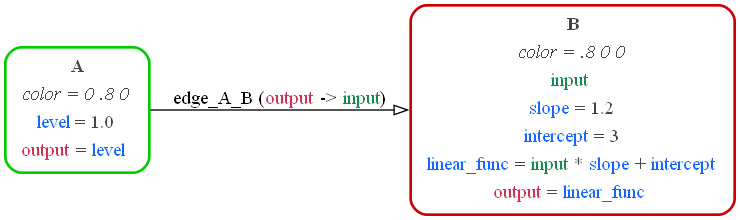

In [23]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="AB",
        is_horizontal=True
    )

from IPython.display import Image
Image(filename="AB.png")

# 3. Execute the graph & print the output values <a class="anchor" id="h3"></a>

The Graph is converted to an [EvaluableGraph](https://mdf.readthedocs.io/en/latest/api/_autosummary/modeci_mdf.execution_engine.EvaluableGraph.html#modeci_mdf.execution_engine.EvaluableGraph), which can be used to evaluate the current state of the graph's parameters. 

### 3.1 Execute the graph with the current parameter values 

In [24]:
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
eg.evaluate()

print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B: %s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)


Init graph: ab_example
Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A: 1
Output of B: 4.2


### 3.2 Change a value to a Numpy array & execute the graph again

An important point about MDF is that the parameters etc. don't just have to be scalar/float values, but can be arrays, such as a Numpy array.

In [25]:
import numpy as np 
#Convert the value of the parameter to a numpy array
a_node.get_parameter('level').value = np.array([[1,2],[3,4]])

eg.evaluate()

print('Output of A:\n%s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)
print('Output of B:\n%s'%eg.enodes["B"].evaluable_outputs["output"].curr_value)

Evaluating graph: ab_example, root nodes: ['A'], with array format numpy
Output of A:
[[1 2]
 [3 4]]
Output of B:
[[4.2 5.4]
 [6.6 7.8]]


# 4. Stateful Parameters in MDF <a class="anchor" id="h4"></a>
Stateful parameters are a special class of [Parameter](https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter) whose value can change each time the model is executed.

### 4.1 Create a Node

In [26]:
# Create a model 
mod = Model(id="States")
mod_graph = Graph(id="state_example")
mod.graphs.append(mod_graph)

a_node = Node(id="A")
mod_graph.nodes.append(a_node)

#https://mdf.readthedocs.io/en/latest/api/Specification.html#parameter
#Add a stateless parameter - this is a parameter which will evaluate to the same value every execution of the node (for the same external inputs)
a_node.parameters.append(Parameter(id="increment", value=1.0))

#Add a stateful parameter - this is a parameter whose value is influenced by a previous value of a parameter, possibly itself
p1 = Parameter(
    id="count",
    value="count + increment",
)
a_node.parameters.append(p1)


# Add an output port
a_node.output_ports.append(OutputPort(id="output", value="count"))

# Print the current structure
print(mod_graph.to_yaml())



state_example:
    nodes:
        A:
            parameters:
                increment:
                    value: 1.0
                count:
                    value: count + increment
            output_ports:
                output:
                    value: count



### 4.2. Generate a graph image from the model 

A graphical representation of the new node is created. Note the stateful parameter name is in **bold**. 

Converting MDF graph: state_example to graphviz (level: 3, format: png)
    Node: A
Written graph image to: states.png


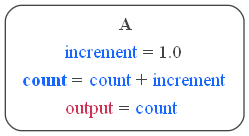

In [27]:

mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="states"
    )

from IPython.display import Image
Image(filename="states.png")


### 4.3. Execute the graph & print the output values
The Graph is converted into an [EvaluableGraph](https://mdf.readthedocs.io/en/latest/api/_autosummary/modeci_mdf.execution_engine.EvaluableGraph.html#modeci_mdf.execution_engine.EvaluableGraph),which can be used to evaluate the current state of the graph's parameters.

In [28]:
#Evaluating the graph once and printing out the output value
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
eg.evaluate()

print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)


Init graph: state_example
Evaluating graph: state_example, root nodes: ['A'], with array format numpy
Output of A: 1


In [29]:
#Evaluating the Graph 5 more times using a time series & changing time increment by 1 
# (so count is 6 at the end, as it already has value 1)
dt = 1
duration = 5
t = 0
times = []
while t < duration:
    times.append(t)
    print("===== Evaluating at t = %s  ======" % (t))
    if t == 0:
        eg.evaluate(array_format=format)
    else:
        eg.evaluate(time_increment=dt)
    #notice that the output increments by 1 because of the stateful parameter setup on the node    
    print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value)    
    t += dt


===== Evaluating at t = 0  ======
Evaluating graph: state_example, root nodes: ['A'], with array format <built-in function format>
Output of A: 2
===== Evaluating at t = 1  ======
Evaluating graph: state_example, root nodes: ['A'], with array format numpy
Output of A: 3
===== Evaluating at t = 2  ======
Evaluating graph: state_example, root nodes: ['A'], with array format numpy
Output of A: 4
===== Evaluating at t = 3  ======
Evaluating graph: state_example, root nodes: ['A'], with array format numpy
Output of A: 5
===== Evaluating at t = 4  ======
Evaluating graph: state_example, root nodes: ['A'], with array format numpy
Output of A: 6


# 5. Conditions in MDF <a class="anchor" id="h5"></a>
In MDF, Conditions are a set of descriptors which specify & determine how many times individual [Nodes](https://mdf.readthedocs.io/en/latest/api/Specification.html#node) are allowed to execute.
To learn more about Conditions see [here](https://github.com/ModECI/MDF/blob/main/examples/MDF/conditions/README.md) and also [Graph-Scheduler](https://kmantel.github.io/graph-scheduler/Condition.html)

### 5.1 Create another [Node](https://mdf.readthedocs.io/en/latest/api/Specification.html#node)

In [30]:
#import the necessary package to use Conditions in MDF
import graph_scheduler

mod_graph.id = 'conditions_example'

b_node = Node(id="B")
mod_graph.nodes.append(b_node)

# Add a parameters
b_node.parameters.append(Parameter(id="param_B", value="param_B + 1"))

# Add an output port
b_node.output_ports.append(OutputPort(id="output", value="param_B"))

# Print current structure as YAML
print(mod_graph.to_yaml())

conditions_example:
    nodes:
        A:
            parameters:
                increment:
                    value: 1.0
                count:
                    value: count + increment
            output_ports:
                output:
                    value: count
        B:
            parameters:
                param_B:
                    value: param_B + 1
            output_ports:
                output:
                    value: param_B



### 5.2 Add Conditions 
To Node B, add a [Pre-Specified](https://kmantel.github.io/graph-scheduler/Condition.html#list-of-pre-specified-conditions), Node-Based Condition, [EveryNCalls](https://kmantel.github.io/graph-scheduler/Condition.html?highlight=everyncalls#graph_scheduler.condition.EveryNCalls)

In [31]:
#This condition means that A is always executed
cond_a = Condition(type="Always")

#This condition means that B will execute when A has run 3 times
cond_b = Condition(type="EveryNCalls", dependencies=a_node.id, n=3)  


In [32]:
#add the conditions to the Graph
mod_graph.conditions = ConditionSet(
    node_specific={a_node.id: cond_a, b_node.id: cond_b},
)

# Print the current structure
print(mod_graph.to_yaml())

conditions_example:
    nodes:
        A:
            parameters:
                increment:
                    value: 1.0
                count:
                    value: count + increment
            output_ports:
                output:
                    value: count
        B:
            parameters:
                param_B:
                    value: param_B + 1
            output_ports:
                output:
                    value: param_B
    conditions:
        node_specific:
            A:
                type: Always
                kwargs: {}
            B:
                type: EveryNCalls
                kwargs:
                    dependencies: A
                    n: 3



### 5.3. Generate a graph image from the model 

Converting MDF graph: conditions_example to graphviz (level: 2, format: png)
    Node: A
    Node: B
Written graph image to: conditions.png


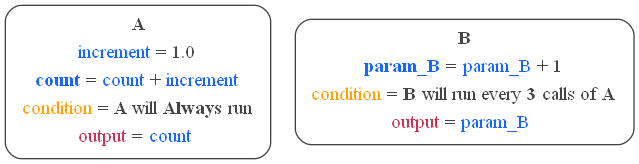

In [33]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=2,
        filename_root="conditions"
    )

from IPython.display import Image
Image(filename="conditions.png")

### 5.4 Execute the Graph
The Graph is converted into an [EvaluableGraph](https://mdf.readthedocs.io/en/latest/api/_autosummary/modeci_mdf.execution_engine.EvaluableGraph.html#modeci_mdf.execution_engine.EvaluableGraph),which can be used to evaluate the current state of the graph's parameters. 


In [34]:
from modeci_mdf.execution_engine import EvaluableGraph

eg = EvaluableGraph(mod_graph, verbose=False)
#Calling the evaluate method will print out the order of the execution of Nodes per the set conditions
#Expected to be ('A','A','A','B')
eg.evaluate()

#The Output of A expected to be 3 as it executes 3 times
print('Output of A: %s'%eg.enodes["A"].evaluable_outputs["output"].curr_value) 

#The Output of B expected to be 1 as it executes only once
print('Output of B: %s'%eg.enodes["B"].evaluable_outputs["output"].curr_value) 


Init graph: conditions_example
Evaluating graph: conditions_example, root nodes: ['A', 'B'], with array format numpy
Output of A: 3
Output of B: 1
